# Kaggle Competition: House Prices: Advanced Regression Techniques
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
## Part 1: Machine Learning
### Outline:
1. Preparation
2. Testing and Selecting Base Models
3. Finetuning of the Best Model
4. Comparison with simple DLN

In [87]:
# Preparation: Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, Normalizer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor,GradientBoostingRegressor
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import r2_score, make_scorer
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from kaggle_scorer import rmsle, rmsle_validation
import keras
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout
import tensorflow as tf

In [88]:
# Preparation: Import processed dataset
path = 'train_processed.csv'
df = pd.read_csv(path, index_col='Id')

df.head()

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice_log
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,2,2008,WD,Normal,12.247694
2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,...,0,0,0,0,0,5,2007,WD,Normal,12.109011
3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,...,0,0,0,0,0,9,2008,WD,Normal,12.317167
4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,...,272,0,0,0,0,2,2006,WD,Abnorml,11.849398
5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,...,0,0,0,0,0,12,2008,WD,Normal,12.429216


In [89]:
# Preparation: Split the dataset in train and test data
X = np.array(df.drop('SalePrice_log',axis=1))
y = np.array(df.loc[:,'SalePrice_log'])

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.80,shuffle=True)

C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [90]:
# Preparation: Prepare Pipelines
poly_fit = PolynomialFeatures(degree=2)
encoder = OneHotEncoder(handle_unknown='ignore')
norm = Normalizer()
scaler = StandardScaler(with_mean=False)

lin_reg = LinearRegression()
rand_for = RandomForestRegressor()
ada_boost = AdaBoostRegressor()
grad_boost = GradientBoostingRegressor()

lin_pipe = Pipeline([('OneHotEncoder',encoder),
                     ('StandardScaler',scaler),
                     ('LinearRegression',lin_reg)])

rand_for_pipe = Pipeline([('OneHotEncoder',encoder),
                          ('StandardScaler',scaler),
                          ('RandomForest',rand_for)])

ada_boost_pipe = Pipeline([('OneHotEncoder',encoder),
                           ('StandardScaler',scaler),
                           ('AdaBoost',ada_boost)])

grad_boost_pipe = Pipeline([('OneHotEncoder',encoder),
                            ('StandardScaler',scaler),
                            ('GradientBoosting',grad_boost)])

In [91]:
# Testing and Selecting Base Models: Defining test function
def test_model(pipeline,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test):
    
    start_time = dt.datetime.now()
    pipeline.fit(X_train,y_train)
    end_time = dt.datetime.now()
    fit_time = dt.timedelta.total_seconds(end_time-start_time)
    
    yhat_train = pipeline.predict(X_train)
    train_score = rmsle(y_train,yhat_train,True)
    
    yhat = pipeline.predict(X_test)
    test_score = rmsle(y_test,yhat,True)
    
    return np.array((fit_time,train_score,test_score))


In [92]:
# Testing and Selecting Base Models: Testing
pipe_list = [lin_pipe,rand_for_pipe,ada_boost_pipe,grad_boost_pipe]
results = np.empty((4,3))

test_map = map(test_model,pipe_list)
i = 0
for result in test_map:
    results[i]=result
    i+=1

C:\Users\Marco\Anaconda3\envs\kaggle_housing_comp\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


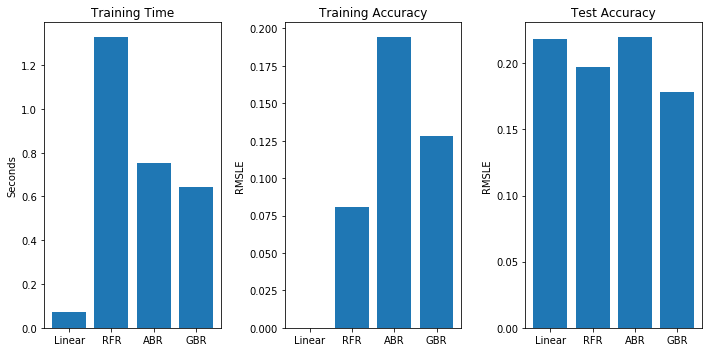

[[7.28060000e-02 1.77952794e-07 2.18368774e-01]
 [1.32888400e+00 8.05247543e-02 1.96820485e-01]
 [7.51496000e-01 1.94323804e-01 2.19921073e-01]
 [6.42732000e-01 1.28125082e-01 1.78223664e-01]]


In [94]:
# Testing and Selecting Base Models: Visualize Test Results
fig,ax = plt.subplots(figsize=(10,5))
names = ['Linear','RFR','ABR','GBR']
titles = ['Training Time','Training Accuracy','Test Accuracy']
y_titles = ['Seconds','RMSLE','RMSLE']
plot_info = zip(titles,y_titles)

for i,titles in enumerate(plot_info):
    plt.subplot(1,3,i+1)
    plt.bar(x=names,height=results[:,i])
    plt.title(titles[0])
    plt.ylabel(titles[1])
    
plt.tight_layout()
plt.show()

print(results)

It is apparent, that the linear model tales the least training time, thanks to its simplicity. It's  And although it is performing well on the training and the test set, it is the least fitting one. Luckily, the second fastest model (GBR) is also the best model in terms of test accuracy, which is why, we will go with that model for now. 

In [ ]:
# Finetuning of the best model: Define hyperparameters to be tuned
param_grid = {'GradientBoosting__learning_rate':[0.001,0.005,0.01,0.1],
              'GradientBoosting__n_estimators':[50,100,200],
              'GradientBoosting__max_depth':[1,3,5]}

grad_boost_pipe_cv = GridSearchCV(grad_boost_pipe,param_grid=param_grid,cv=3,n_jobs=-1)

In [ ]:
# Finetuning of the best model: Fit final model
grad_boost_pipe_cv.fit(X_train,y_train)

final_results = test_model(grad_boost_pipe_cv)

In [ ]:
# Finetuning of the best model: Display final results
print('Total Runtime: {}'.format(final_results[0]))
print('Training Score (RMSLE): {}'.format(final_results[1]))
print('Test Score (RMSLE) {}'.format(final_results[2]))

In [76]:
# Best model versus Deep Learning Network: Special pipeline
dln_pipe = Pipeline([('OneHotEncoder',encoder),
                     ('StandardScaler',scaler),
                     ('TruncatedSVD',TruncatedSVD(n_components=25))])

input_train = dln_pipe.fit_transform(X_train)
labels_train = y_train.reshape(-1,1)
input_test = dln_pipe.fit_transform(X_test)
labels_test = y_test.reshape(-1,1)

In [77]:
model = Sequential()
model.add(Dense(128,kernel_initializer='normal',input_dim=input_train.shape[1],activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256,kernel_initializer='normal',activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1,kernel_initializer='normal',activation='linear'))

model.compile(loss = 'mean_absolute_error',optimizer='sgd',metrics=['mean_absolute_error'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 128)               3328      
_________________________________________________________________
dropout_34 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_35 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_54 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_36 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 256)               65792     
__________

In [84]:
model.fit(input_train,labels_train,epochs=500,batch_size=64,validation_split=0.2,verbose=0,shuffle=True)

In [85]:
yhat = model.predict_on_batch(input_test)
print(yhat)
dln_score = rmsle(labels_test,yhat,True)

[[12.415481 ]
 [11.622877 ]
 [12.348018 ]
 [11.7417555]
 [11.542271 ]
 [11.560595 ]
 [11.786009 ]
 [12.388378 ]
 [11.706745 ]
 [11.918928 ]
 [12.290341 ]
 [12.2939415]
 [11.593943 ]
 [12.319513 ]
 [10.690809 ]
 [12.104761 ]
 [12.375968 ]
 [11.710403 ]
 [10.821026 ]
 [11.910979 ]
 [12.089603 ]
 [10.98204  ]
 [11.9617   ]
 [12.330634 ]
 [12.206755 ]
 [11.694557 ]
 [12.2328205]
 [12.268235 ]
 [12.281645 ]
 [11.560022 ]
 [12.306289 ]
 [12.1777   ]
 [11.786619 ]
 [12.170998 ]
 [12.396748 ]
 [11.543527 ]
 [11.83569  ]
 [12.280916 ]
 [11.773104 ]
 [11.671526 ]
 [11.898701 ]
 [12.144026 ]
 [11.892946 ]
 [11.926736 ]
 [11.68622  ]
 [12.333905 ]
 [11.497539 ]
 [12.556831 ]
 [11.446682 ]
 [12.218968 ]
 [12.382299 ]
 [11.458521 ]
 [12.221041 ]
 [12.356464 ]
 [11.774463 ]
 [12.346512 ]
 [12.5552   ]
 [11.9028   ]
 [12.416607 ]
 [11.618839 ]
 [12.084577 ]
 [12.013269 ]
 [12.404454 ]
 [11.743118 ]
 [12.164206 ]
 [12.363142 ]
 [11.8956175]
 [11.73562  ]
 [12.359972 ]
 [12.285374 ]
 [12.187336 ]
 [11.9

In [86]:
# TODO: Compare results of best untuned ML model, best tuned ML model and deep learning network.
# print('Best untuned ML model: {}'.format(results[-1:-1]))
# print('Best tuned ML model: {}'.format(final_results[-1]))
print('Best Deep Learning model: {}'.format(dln_score))

Best Deep Learning model: 0.3718127962848793


In [ ]:
# TODO: Use test_processed.csv to make submission-ready predictions.